# Chapter 3a: Basics of Support Vector Machines (SVM)

Support vector machines (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression (although SVM is mostly used in classification). In this section, we will develop the intuition behind support vector machines and their use in classification problems. We will finally make a simple geoscience application in the context of rock stability analysis in the mining industry.

Note that we will use `seaborn` as plotting default in this notebook. It is a Python data visualization library based on `matplotlib`. It provides a high-level interface for drawing attractive and informative statistical graphics.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import seaborn as sns; sns.set()

from sklearn.svm import SVC     # "Support vector classifier"
from sklearn.datasets import make_blobs, make_circles

from mpl_toolkits import mplot3d

## 1. Generalities

### 1.1. Motivating Support Vector Machines

SVM consists in discriminative classification: rather than modeling each class, it simply finds a line or curve (in two dimensions) or manifold (in multiple dimensions) that divides the classes from each others. As an example of this, consider the simple case of a classification task, in which the two classes of points are well separated (here simulated using the function `make_blobs`):

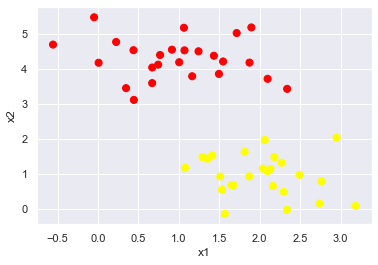

In [2]:
X, y = make_blobs(n_samples = 50, centers = 2, random_state = 0, cluster_std = .6)

plt.scatter(X[:, 0], X[:, 1], c = y, s = 50, cmap = 'autumn')
plt.xlabel('x1')
plt.ylabel('x2');

A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification. For two dimensional data like that shown here, this is a task we could do by hand. But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

We can draw them as follows:

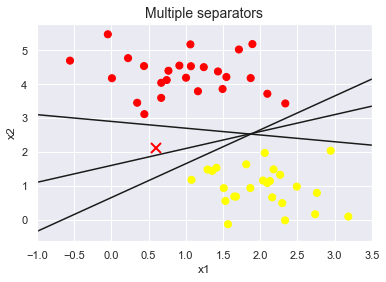

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Multiple separators', size = 14)
plt.xlim(-1, 3.5);

These are three very different separators which, nevertheless, perfectly discriminate between these samples. Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label! Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

### 1.2. Support Vector Machines: Maximizing the Margin

Support vector machines offer one way to improve on this. The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a margin of some width, up to the nearest point. Here is an example of how this might look:

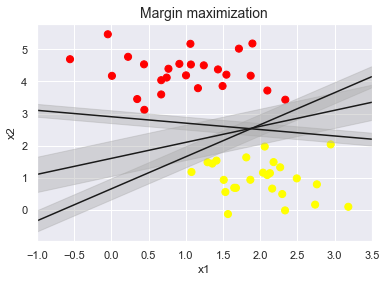

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Margin maximization', size = 14)
plt.xlim(-1, 3.5);

In support vector machines, the line that maximizes this margin (i.e. __Maximum-Margin Hyperplane (MMH)__) is the one we will choose as the optimal model.

### 1.3. Fitting a SVM

Let us see the result of an actual fit to this data: we will use the `sklearn` support vector classifier `SVC()` to train an SVM model on this data. For the time being, we will use a linear kernel and set the $C$ parameter to a very large number (we'll discuss the meaning of these in more depth below).

In [5]:
model = SVC(kernel='linear', C = 1E10)
model.fit(X, y)

SVC(C=10000000000.0, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

To better visualize what's happening, let's create a function that will plot SVM decision boundaries for us:

In [6]:
def plot_svc_decision_function(model, ax = None, plot_support = True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s = 300, linewidth = 1, edgecolors = 'black', facecolors = 'none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

**EXERCISE 1:** Understand the concept of decision function based on the code provided above (`decision_function`). Print out some values of the decision function below and explain in words what those values indicate. The next plot should be helpful.

In [7]:
# YOUR CODE HERE
xi = np.linspace(min(X[:, 0]),max(X[:, 0]),5)
yi = np.linspace(min(X[:, 1]),max(X[:, 1]),5)
y_tmp, x_tmp = np.meshgrid(yi,xi)
xy =np.vstack([x_tmp.ravel(),y_tmp.ravel()]).T
model.decision_function(xy)


array([ 3.36072635,  1.37885129, -0.60302378, -2.58489884, -4.56677391,
        3.58073169,  1.59885662, -0.38301845, -2.36489351, -4.34676858,
        3.80073702,  1.81886195, -0.16301311, -2.14488818, -4.12676325,
        4.02074235,  2.03886728,  0.05699222, -1.92488285, -3.90675791,
        4.24074768,  2.25887262,  0.27699755, -1.70487752, -3.68675258])

_YOUR ANSWER HERE_

Values larger than 0 means these points belong to one class, and values smaller than 0 means these points belong to another class. The greater the absolute value, the longer the distance to dividing line. 

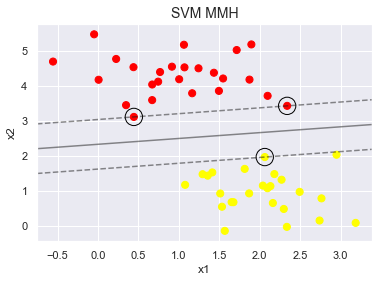

In [8]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('SVM MMH', size = 14)

plot_svc_decision_function(model)

This is the dividing line that maximizes the margin between the two sets of points. Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure. These points are the pivotal elements of this fit, and are known as the support vectors, and give the algorithm its name. The identity of these points are stored in the `support_vectors_` attribute of the classifier.

**EXERCISE 2:** Print the coordinates of the support vectors of our SVM model.

In [9]:
# YOUR CODE HERE
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit! Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

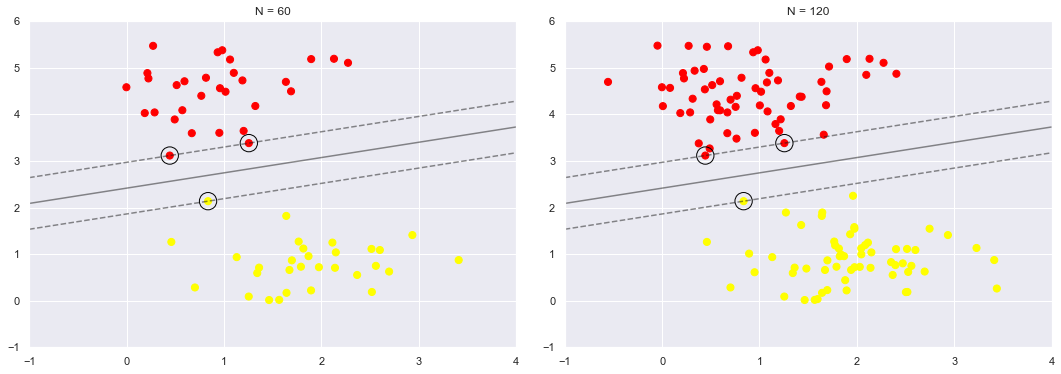

In [10]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In the left panel, we see the model and the support vectors for 60 training points. In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors from the left panel are still the support vectors from the right panel. This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

### 1.4. Beyond linear boundaries: Kernel SVM

Where SVM becomes extremely powerful is when it is combined with kernels. We have seen a version of kernels before, in the basis function regressions in chapter 2c (on nonlinear regression). There we projected our data into higher-dimensional space defined by polynomials and Gaussian basis functions, and thereby were able to fit for nonlinear relationships with a linear classifier.

In SVM models, we can use a version of the same idea. To motivate the need for kernels, let's look at some data that is not linearly separable:

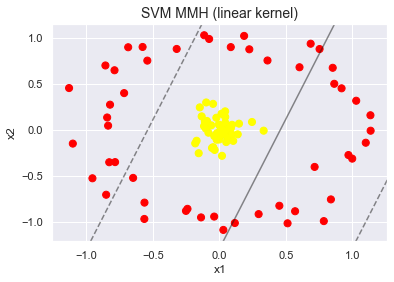

In [11]:
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c = y, s = 50, cmap = 'autumn')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('SVM MMH (linear kernel)', size = 14)

plot_svc_decision_function(clf, plot_support=False)

It is clear that no linear discrimination will ever be able to separate this data. But we can draw a lesson from the basis function regressions, and think about how we might project the data into a higher dimension such that a linear separator would be sufficient. For example, one simple projection we could use would be to compute a __radial basis function__ centered on the middle clump:

In [12]:
r = np.exp(-(X ** 2).sum(1))

**EXERCISE 3:** Find a simple way to visualise that the data is now linearly separable into two classes thanks to the use of a radial basis function.

Text(0.5, 1.0, 'nonlinear transform')

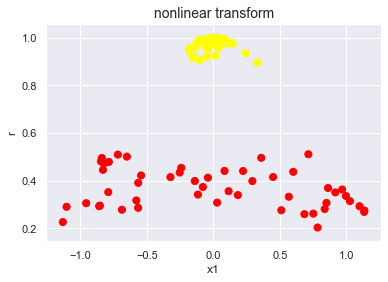

In [13]:
# YOUR CODE HERE
plt.scatter(X[:, 0], r, c = y, s = 50, cmap = 'autumn')
plt.xlabel('x1')
plt.ylabel('r')
plt.title('nonlinear transform', size = 14)

We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at, say, r=0.7.

Here we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results. In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.

One strategy to this end is to compute a basis function centered at every point in the dataset, and let the SVM algorithm go through the results. This type of basis function transformation is known as a __kernel transformation__, as it is based on a similarity relationship (or kernel) between each pair of points.

A potential problem with this strategy — projecting $N$ points into $N$ dimensions — is that it might become very computationally intensive as $N$ grows large. However, because of a neat little procedure known as the kernel trick, a fit on kernel-transformed data can be done implicitly—that is, without ever building the full $N$-dimensional representation of the kernel projection! This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

In `SVC`, we can apply kernelized SVM simply by changing our linear kernel to an __RBF (radial basis function) kernel__, using the kernel model hyperparameter:

In [14]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

**EXERCISE 4:** Plot the result for the SVM model with RBF kernel. Plot also the margins and support vectors.

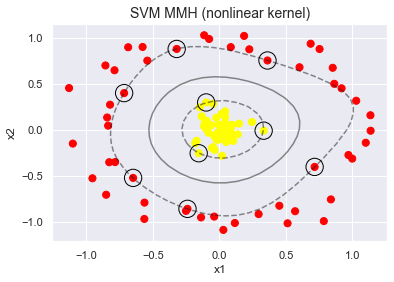

In [15]:
plt.scatter(X[:, 0], X[:, 1], c = y, s = 50, cmap = 'autumn')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('SVM MMH (nonlinear kernel)', size = 14)

plot_svc_decision_function(clf)

Using this kernelized SVM, we learn a suitable nonlinear decision boundary. This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

### 1.5. Tuning the SVM: Softening Margins

Our discussion thus far has centered around very clean datasets, in which a perfect decision boundary exists. But what if your data has some amount of overlap? For example, you may have data like this:

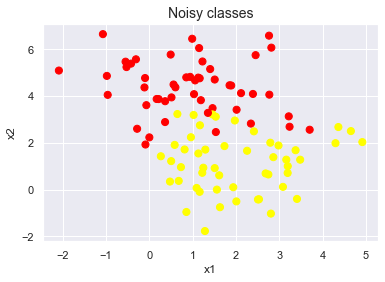

In [16]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Noisy classes', size = 14);

To handle this case, the SVM implementation has a hyperparameter which "softens" the margin: that is, it allows some of the points to cross into the margin if that allows a better fit. The hardness of the margin is controlled by a tuning parameter, most often known as $C$. For very large $C$, the margin is hard, and points cannot lie in it. For smaller $C$, the margin is softer, and can grow to encompass some points.

The plot shown below gives a visual picture of how a changing $C$ parameter affects the final fit, via the softening of the margin:

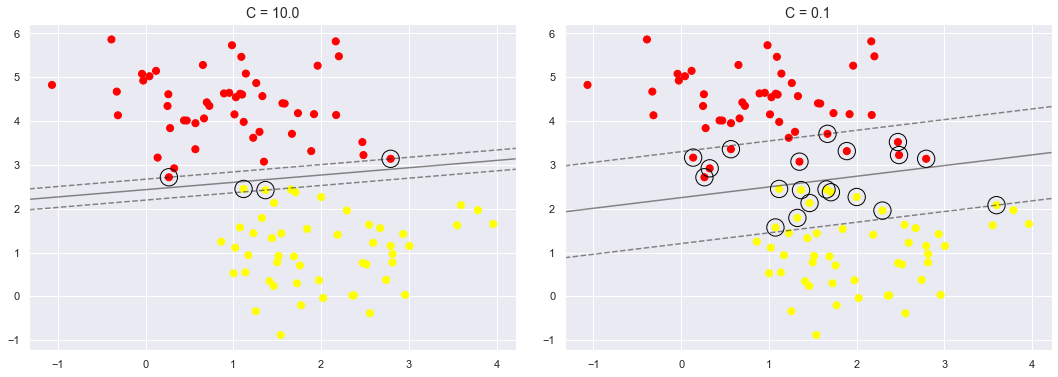

In [17]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

The optimal value of the $C$ parameter will depend on the dataset, and should be tuned using cross-validation or a similar procedure (refer back to the previous chapter).

## 2. Application: SVM for multi-class geophysical problem

Let us apply what we just learned to classify rock stability in the mining industry. This requires some more details about SVM in the multi-class context:

### 2.1. A multi-class example

The multiclass problem is broken down to multiple binary classification cases, which is also called one-vs-one. In scikit-learn one-vs-one is not default and needs to be selected explicitly (as can be seen further down in the code). One-vs-rest is set as default. It basically divides the data points in class $y$ and rest. Consecutively a certain class is distinguished from all other classes. The number $n$ of classifiers necessary for one-vs-one multiclass classification is $n(n-1)/2$.

The mining industry relies heavily on empirical analysis for design and prediction. An empirical design method, called the critical span graph, was developed specifically for rock stability analysis in entry-type excavations, based on an extensive case-history database of cut and fill mining in Canada. This empirical span design chart plots the critical span against rock mass rating for the observed case histories and has been accepted by many mining operations for the initial span design of cut and fill stopes. Different types of analysis have been used to classify the observed cases into stable, potentially unstable and unstable groups (García-Gonzalo et al., 2016). The data is named `materials-09-00531-s001.csv`.

<img src="figs_notebook/fig_ref_García-Gonzalo.png" width = 500>

**EXERCISE 5:** Load and plot the data provided by García-Gonzalo et al. (2016). Labelling is as follows: 1 = stable, 2 = potentially unstable, 3 = unstable.

In [19]:
# YOUR CODE HERE
import pandas as pd
data_ = pd.read_csv('C://Users//79092//Desktop//地球科学与机器学习//chapter3//materials-09-00531-s001.csv')
data_

,Number,RMR(%),Span(m),Stability
0,1,55,18.6,2
1,2,77,12.0,1
2,3,40,6.4,3
3,4,57,13.0,1
4,5,47,9.2,2
...,...,...,...,...
394,395,85,16.0,1
395,396,55,7.0,1
396,397,61,6.4,1
397,398,77,25.0,1


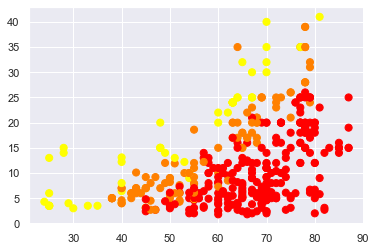

In [20]:
x_ = data_[['RMR(%)','Span(m)']].values
y_ = data_['Stability'].values
plt.scatter(x_[:, 0], x_[:, 1], c=y_, s=50, cmap='autumn')

**EXERCISE 6:** Develop a first SVM classifier with linear kernel and show the margins separating the different classes by ploting the SVM predicted class in a mesh. We don't want to test the performance of the model, just separate the different classes, so use all the data for model fitting.

Text(0.5, 1.0, 'Linear SVM, Acc = 0.8170426065162907')

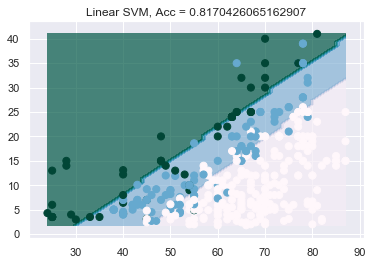

In [46]:
# YOUR CODE HERE
model_linear = SVC(kernel='linear', C = 0.01)
model_linear.fit(x_, y_)
#create the mesh
#h = 1
#x_min, x_max = x[:,fi].min()-1, x[:,fi].max()+1
#y_min, y_max = 
#xx, yy = np.meshgrid(vector of x, vector of y)
xi = np.linspace(min(x_[:, 0]),max(x_[:, 0]),50)
yi = np.linspace(min(x_[:, 1]),max(x_[:, 1]),50)
y_tmp, x_tmp = np.meshgrid(yi,xi)
# xy =np.vstack([x_tmp.ravel(),y_tmp.ravel()]).T
# model_linear.decision_function(xy)

# predict 
Z = model_linear.predict(np.c_[x_tmp.ravel(), y_tmp.ravel()])   #rearrange the format

# Put the result into a color plot
Z = Z.reshape(y_tmp.shape)
plt.contourf(x_tmp, y_tmp,Z, cmap = plt.cm.PuBuGn,alpha = .7)
plt.scatter(x_[:, 0], x_[:, 1], c=y_, s=50, cmap=plt.cm.PuBuGn)
title_ = 'Linear SVM, Acc = ' + str(model_linear.score(x_,y_))
plt.title(title_)

**EXERCISE 7:** Change the value of $C$ and investigate the impact on model accuracy (`model.score(x,y)` parameter). You may rerun the previous cell(s) but write down your observations below.

_YOUR ANSWER HERE_ :I find a smaller C will cause a smaller accuracy

**EXERCISE 8:** Develop a second SVM classifier with RBF kernel and plot the same as in the previous exercise. Calculate the accuracy of the model. Is it better than with the linear kernel?

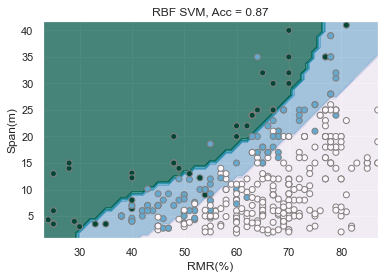

In [40]:
model_rbf = SVC(kernel='rbf', C = 0.01)
model_rbf.fit(x_, y_)
#create the mesh
#h = 1
#x_min, x_max = x[:,fi].min()-1, x[:,fi].max()+1
#y_min, y_max = 
#xx, yy = np.meshgrid(vector of x, vector of y)
xi = np.linspace(min(x_[:, 0]),max(x_[:, 0]),50)
yi = np.linspace(min(x_[:, 1]),max(x_[:, 1]),50)
y_tmp, x_tmp = np.meshgrid(yi,xi)
# xy =np.vstack([x_tmp.ravel(),y_tmp.ravel()]).T
# model_linear.decision_function(xy)

# predict 
Z = model_rbf.predict(np.c_[x_tmp.ravel(), y_tmp.ravel()])   #rearrange the format

# Put the result into a color plot
Z = Z.reshape(y_tmp.shape)
plt.contourf(x_tmp, y_tmp,Z, cmap = plt.cm.PuBuGn,alpha = .7)
plt.scatter(x_[:, 0], x_[:, 1], c=y_, s=50, cmap=plt.cm.PuBuGn)
title_ = 'RBF SVM, Acc = ' + str(model_linear.score(x_,y_))
plt.title(title_)

Text(0.5, 1.0, 'RBF SVM, Acc = 0.8696741854636592')

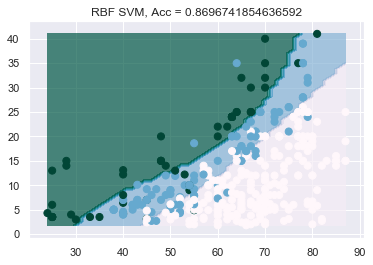

In [67]:
# YOUR CODE HERE
model_rbf = SVC(kernel='rbf', C = 10)
model_rbf.fit(x_, y_)
#create the mesh
#h = 1
#x_min, x_max = x[:,fi].min()-1, x[:,fi].max()+1
#y_min, y_max = 
#xx, yy = np.meshgrid(vector of x, vector of y)
xi = np.linspace(min(x_[:, 0]),max(x_[:, 0]),50)
yi = np.linspace(min(x_[:, 1]),max(x_[:, 1]),50)
y_tmp, x_tmp = np.meshgrid(yi,xi)
# xy =np.vstack([x_tmp.ravel(),y_tmp.ravel()]).T
# model_linear.decision_function(xy)

# predict 
Z = model_rbf.predict(np.c_[x_tmp.ravel(), y_tmp.ravel()])   #rearrange the format

# Put the result into a color plot
Z = Z.reshape(y_tmp.shape)
plt.contourf(x_tmp, y_tmp,Z, cmap = plt.cm.PuBuGn,alpha = .7)
plt.scatter(x_[:, 0], x_[:, 1], c=y_, s=50, cmap=plt.cm.PuBuGn)
title_ = 'RBF SVM, Acc = ' + str(model_rbf.score(x_,y_))
plt.title(title_)

In [59]:
y_

array([2, 1, 3, 1, 2, 1, 2, 3, 1, 2, 1, 1, 3, 2, 2, 1, 2, 3, 3, 1, 1, 1,
       1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 3,
       3, 1, 2, 1, 1, 1, 2, 3, 2, 2, 2, 2, 1, 1, 3, 3, 3, 1, 3, 3, 1, 1,
       3, 1, 1, 3, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2,
       1, 2, 1, 1, 3, 1, 1, 2, 1, 1, 1, 3, 3, 1, 3, 1, 1, 1, 1, 3, 1, 1,
       1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 3, 1, 1, 2, 1, 3, 1, 1,
       2, 1, 2, 3, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 3, 2, 1, 1, 1, 2, 1,
       3, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1,
       1, 1, 1, 2, 1, 1, 1, 3, 2, 2, 2, 1, 1, 2, 1, 3, 1, 1, 1, 3, 1, 2,
       1, 1, 2, 1, 3, 1, 3, 2, 3, 1, 3, 1, 1, 2, 1, 1, 3, 1, 3, 1, 2, 1,
       1, 1, 2, 1, 1, 1, 3, 1, 2, 1, 1, 3, 2, 2, 1, 2, 1, 3, 1, 1, 2, 1,
       2, 1, 1, 3, 1, 1, 2, 2, 1, 1, 1, 3, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 3, 3, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2,
       1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 2, 1,

**EXERCISE 9:** Compare the confusion matrix of the two models (table form and graph form, see chapter 2d).

In [71]:
# YOUR CODE HERE
import sklearn
print('Confusion matrix (linear SVM)')
print(sklearn.metrics.confusion_matrix(y_,model_linear.predict(x_)))
print('Confusion matrix (RBF SVM)')
print(sklearn.metrics.confusion_matrix(y_,model_rbf.predict(x_)))


Confusion matrix (linear SVM)
[[221  19   0]
 [ 19  76   8]
 [  1  26  29]]
Confusion matrix (RBF SVM)
[[226  14   0]
 [ 21  80   2]
 [  1  14  41]]


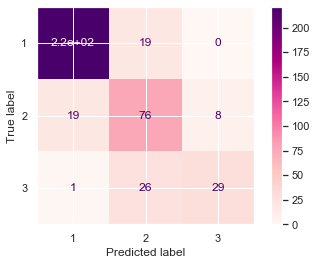

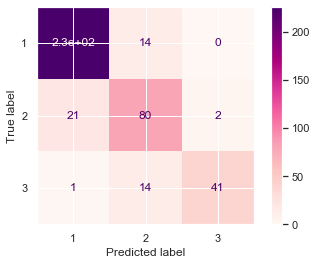

In [81]:
sklearn.metrics.plot_confusion_matrix(model_linear,x_,y_, cmap = 'RdPu')
sklearn.metrics.plot_confusion_matrix(model_rbf,x_,y_, cmap = 'RdPu')

## References

* Cortes, C., Vapnik, V. (1995), Support-Vector Networks. Machine Learning, 20, 273-297
* García-Gonzalo, E., et al. (2016), Hard-Rock Stability Analysis for Span Design in Entry-Type Excavations with Learning Classifiers. Materials, 9, 531, doi:10.3390/ma9070531